In [2]:
import numpy as np
import math
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

# HW4


## Viterbi Implementation

This homework we'll be focusing on Viterbi Algorithm given an existing HMM. The goal of the homework is to find the likelihood of an utterance and the best   state sequence.

* The observed features are 14-dimensional, real-valued speech features, from utterances of “yes”    and “no” sampled every 10 msec. In other words, each input line is a spe
ech sample, 10 msec apart. (See the `input\*.txt` files.)

* Parameters (mean and variance vectors) of two “yes” and “no” GMMs are given . (See the `(mean|var)_\*.txt` files.)

* Transition probabilities of  “yes” and “no” HMMs are given. Each row is the transition probability for one state. For example, row 1 colum 3 is the transition probability from state 1 to state 3 (See the `trans_\*.txt` files.)

* Assume equal initial probabilities.

* Assume that this is a whole-word recognizer, and that each word is recognized with a separate execution of the program. This will greatly simplify the implementation.

* The transition probabilities <font color=red>are</font> in the log domain.

* The mixture weights <font color=red>are NOT</font> in the log domain.

* The covariance values <font color=red>are NOT </font>in the log domain. These covariance values are the diagonal of a 14 by 14 matrix.

* <font color=red> The natural log (e) is used when computing log values. </font>

* Your state sequence plot should look like to stateSeq.pdf.






### What to turn in:

1. Print out final likelihood scores and plot most likely state sequences for:

        A) `input1.txt` given `hmm_yes`

        B) `input1.txt` given `hmm_no`

        C) `input2.txt` given `hmm_yes`

        D) `input2.txt` given `hmm_no`

        E) `input3.txt` given `hmm_yes`

        F) `input3.txt` given `hmm_no`

2. Use results to perform ASR…

    A) is input1.txt more likely to be “yes” or “no”?

    B) is input2.txt more likely to be “yes” or “no”?

    C) is input3.txt more likely to be “yes” or “no”?


Tip: Start small! This way you can always do some "by hand" calculations to verify what your code is doing.

Tip: Don't forget about underflow! For this part of the assignment, it won't be a serious issue, but for the next part, it will be, so code accordingly. If you want, start with real-space probabilities, get things working that way, and then switch to log-probs.

Tip: As you follow along with the algorithm from the book (or from the slides), do watch out for off-by-one errors. The book assumes 1-based indexing, whereas Python starts at 0.

In [3]:
# Functions for file intake
def get_array_from_input_file(filename):
    point_list = []
    with open(filename,"r") as file:
        point_list = np.array([float(x) for x in file.read().split()])
        point_array = point_list.reshape(int(point_list.size/14),14)
    return(point_array)

def get_array_from_transition_file(filename):
    point_list = []
    with open(filename,"r") as file:
        point_lists = [x.split(',') for x in file.read().splitlines()]
        point_array = np.array([[float(y) for y in x] for x in point_lists]).reshape(5,5)
    return(point_array)

def get_array_from_means_or_var_file(filename):
    point_list = []
    with open(filename,"r") as file:
        point_lists = [x.split(',') for x in file.read().splitlines()]
        point_array = np.array([[float(y) for y in x] for x in point_lists]).reshape(14,5)
    return(point_array)



In [13]:
# class used to build and hold model
class Viterbi:
      
    def __init__(self,observation_file, transition_file, mean_file, var_file):
        
        self.title_string = "Input: " + observation_file + "  Using: " + transition_file +" "+ mean_file+ " and " + var_file
        print(self.title_string)
        
        # state variables
        self.run_state = False
        self.backtrack_state = False
        
        # file absorbtioin
        input_file = get_array_from_input_file(observation_file)
        means = get_array_from_means_or_var_file(mean_file)
        var = get_array_from_means_or_var_file(var_file)

        # model components
        self.A = get_array_from_transition_file(transition_file)
        self.B = np.array([[multivariate_normal.logpdf(x,means.T[s],var.T[s]) 
                            for s in range(self.A.shape[0])] for x in input_file])
        self.Pi = np.array([np.log(1.0/self.A.shape[0]) for i in range(self.A.shape[0])])
        self.Delta_t_minus = np.array(np.add(self.B[0].T, self.Pi))
        self.Psi = np.zeros((self.B.shape[0],self.B.shape[1]))
        self.likelihood = 0


    '''helper function for the full run. calculates single delta t from delta t-1
    also adds value to psi array to backtrack over later'''  
    def __step__(self,t):
        # row is current state, column are previous states
        delta_square = np.add(np.tile(self.Delta_t_minus,(self.A.shape[0],1)), self.A.T)
        # new delta
        self.Delta_t = np.array([max(x) for x in delta_square])
        self.Psi[t] = np.array([list(x).index(max(x)) for x in delta_square])
        # push delta t into delta t - 1
        self.Delta_t_minus = np.add(self.Delta_t, self.B[t])

     
    '''makes many calls to step in order to run the full HMM.
    retruns viterbi likelihood.'''
    def run(self):
        num_observations = self.B.shape[0]
        for i in range(1,num_observations):
            self.__step__(i)
        self.likelihood = max(self.Delta_t_minus)
        self.run_state = True
        return self.likelihood

    ''' after model has ran this will run the backtrack on the 
    member variables. returns backtrack as an array.'''
    def backtrack(self):
        if not self.run_state: self.run()
        trace_size = self.Psi.shape[0]
        self.back_trace = list(np.zeros(trace_size))
        start_index = list(self.Delta_t_minus).index(max(self.Delta_t_minus))
        self.back_trace[-1] = start_index
        for i in range(1,trace_size):
            self.back_trace[-i-1] = int(self.Psi[-i][self.back_trace[-i]])
        self.backtrack_state = True
        return self.back_trace
    
    
    def plot_state(self):
        if not self.backtrack_state: self.backtrack()
        plt.figure(figsize=(20,5),facecolor='lightgrey')
        the_title = self.title_string + "   Likelihood: " + str(self.likelihood)
        plt.title(the_title)
        plt.plot(self.back_trace)

In [14]:
input1_yes = Viterbi("input1.txt","trans_YES.txt","mean_YES.txt","var_YES.txt")
input2_yes = Viterbi("input2.txt","trans_YES.txt","mean_YES.txt","var_YES.txt")
input3_yes = Viterbi("input3.txt","trans_YES.txt","mean_YES.txt","var_YES.txt")

input1_no = Viterbi("input1.txt","trans_NO.txt","mean_NO.txt","var_NO.txt")
input2_no = Viterbi("input2.txt","trans_NO.txt","mean_NO.txt","var_NO.txt")
input3_no = Viterbi("input3.txt","trans_NO.txt","mean_NO.txt","var_NO.txt")


Input: input1.txt  Using: trans_YES.txt mean_YES.txt and var_YES.txt
Input: input2.txt  Using: trans_YES.txt mean_YES.txt and var_YES.txt
Input: input3.txt  Using: trans_YES.txt mean_YES.txt and var_YES.txt
Input: input1.txt  Using: trans_NO.txt mean_NO.txt and var_NO.txt
Input: input2.txt  Using: trans_NO.txt mean_NO.txt and var_NO.txt
Input: input3.txt  Using: trans_NO.txt mean_NO.txt and var_NO.txt


## Graphs

### Yes Graphs:

In [15]:
x = input1_yes.run()

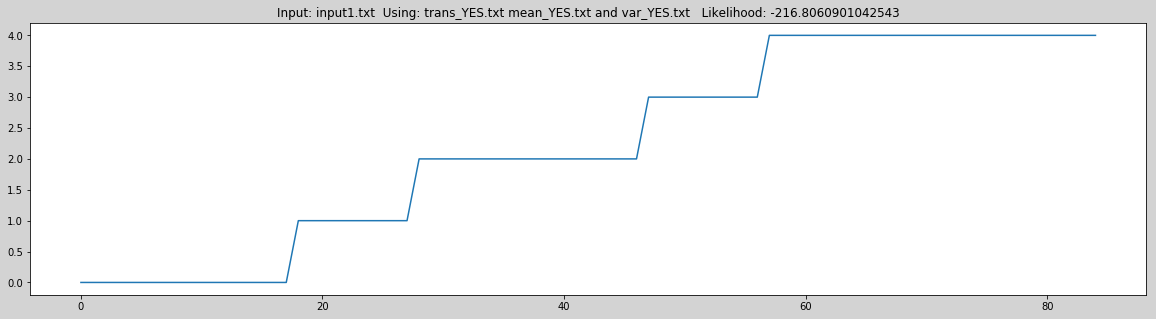

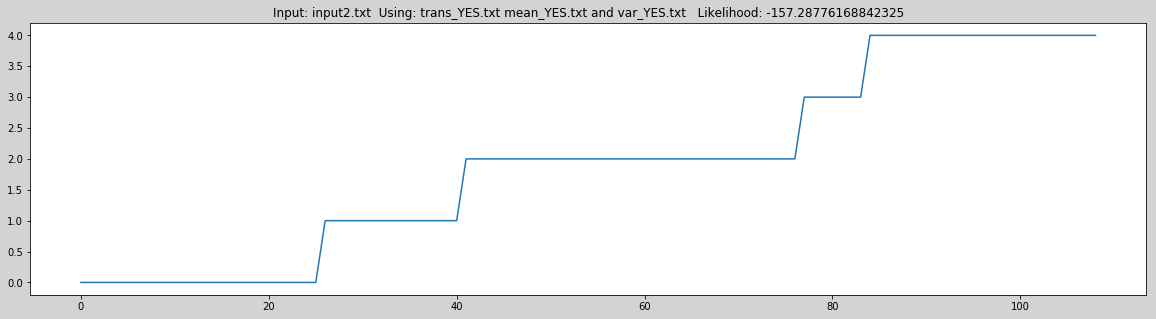

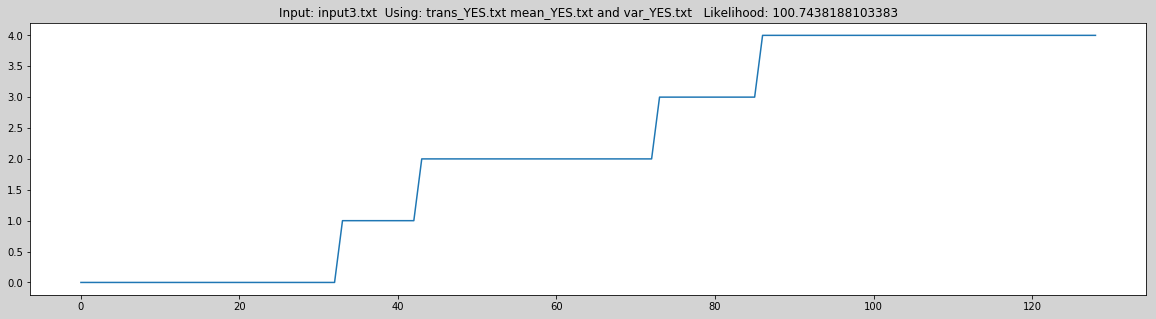

In [16]:
input1_yes.plot_state()
input2_yes.plot_state()
input3_yes.plot_state()


### No Graphs:

[   1.96259066   -9.86366395 -134.84238855   -9.42829262   -2.55198091]
[-21.51094852  -6.06298566 -44.73150054 -17.87990343 -21.99358031]
[  0.23905542  -6.33230825 -94.03060392 -16.93819597  -7.05594213]


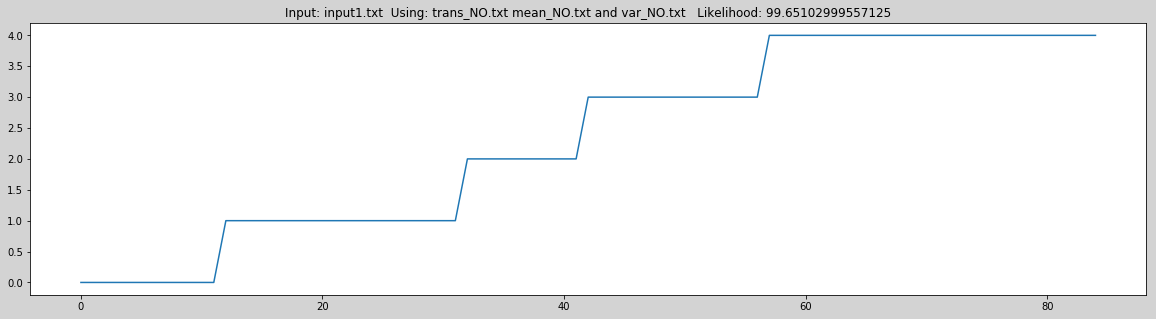

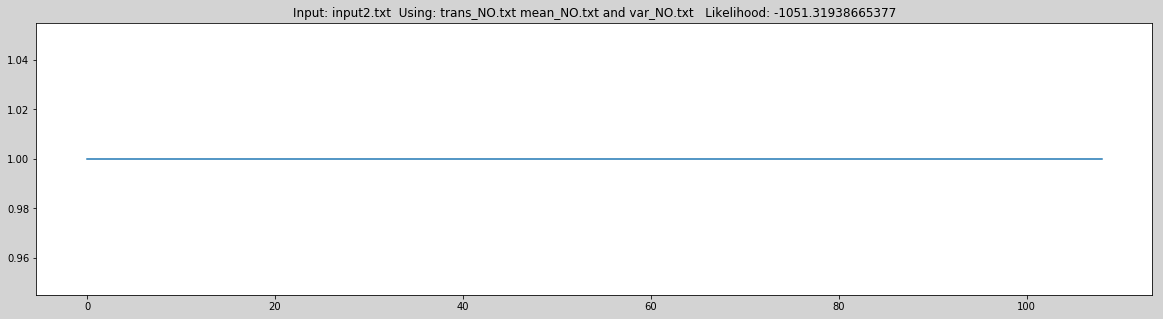

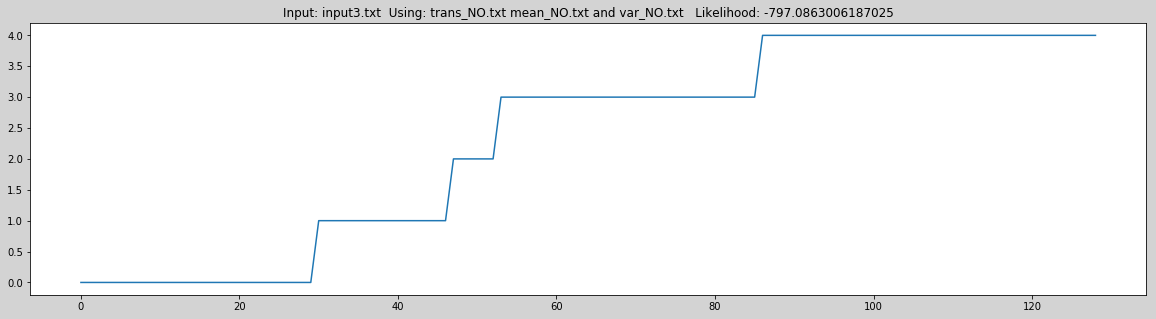

In [8]:
input1_no.plot_state()
input2_no.plot_state()
input3_no.plot_state()

## Classification

In [9]:
def asr(yes_model, no_model):
    print("YES model likelihood: " + str(yes_model.likelihood))
    print("NO model likelihood: " + str(no_model.likelihood))
    if yes_model.likelihood < no_model.likelihood:
        print("Classification: No\n")
    else:
        print("Classification: Yes\n")

In [10]:
asr(input1_yes,input1_no)
asr(input2_yes,input2_no)
asr(input3_yes,input3_no)

YES model likelihood: -216.8060901042543
NO model likelihood: 99.65102999557125
Classification: No

YES model likelihood: -157.28776168842325
NO model likelihood: -1051.31938665377
Classification: Yes

YES model likelihood: 100.7438188103383
NO model likelihood: -797.0863006187025
Classification: Yes




#### input1.txt
YES model likelihood: -216.81<br>
NO model likelihood: 99.65<br>
**Classification: "NO"**<br>

#### input2.txt
YES model likelihood: -157.29 <br>
NO model likelihood: -1051.32<br>
**Classification: "YES"** <br>

#### input3.txt
YES model likelihood: 100.74<br>
NO model likelihood: -797.09<br>
**Classification: "YES"**<br>


<font color=red> self-assessment: </font>

## My solution is correct

Two extra graphs were included in the solution that were not required by the assignment instructions. This is trivial and I include them here for the sake of demonstrating that.

### Validations

Input: yes_validation.txt  Using: trans_YES.txt mean_YES.txt and var_YES.txt
Input: yes_validation.txt  Using: trans_NO.txt mean_NO.txt and var_NO.txt


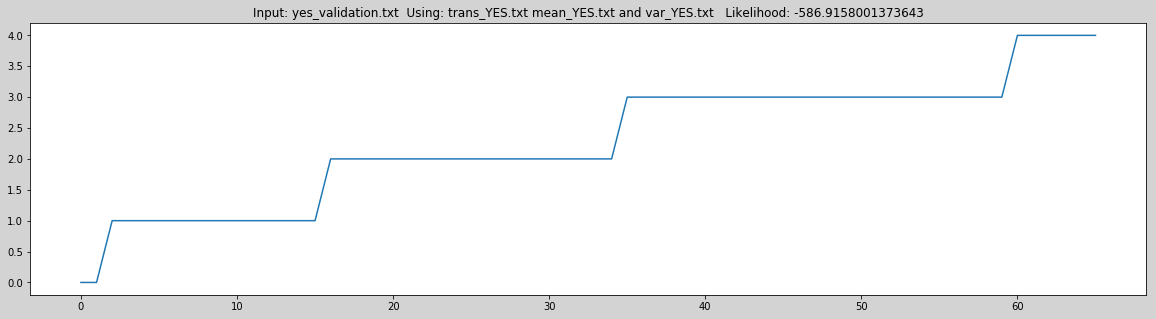

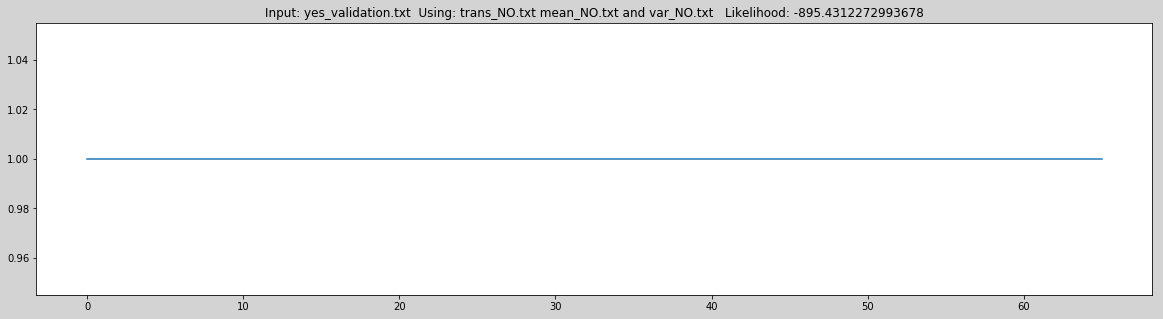

In [18]:
# validate yes model
validate_yes_yes = Viterbi("yes_validation.txt","trans_YES.txt","mean_YES.txt","var_YES.txt")
validate_yes_no = Viterbi("yes_validation.txt","trans_NO.txt","mean_NO.txt","var_NO.txt")

# plot
validate_yes_yes.plot_state()
validate_yes_no.plot_state()


Input: no_validation.txt  Using: trans_YES.txt mean_YES.txt and var_YES.txt
Input: no_validation.txt  Using: trans_NO.txt mean_NO.txt and var_NO.txt


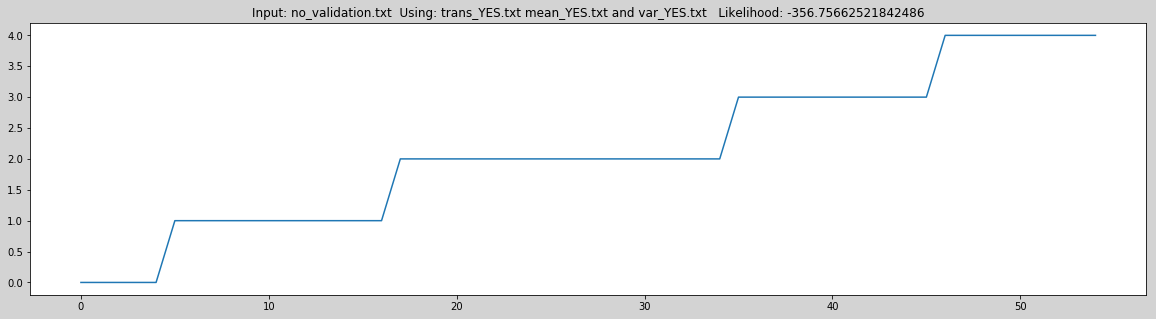

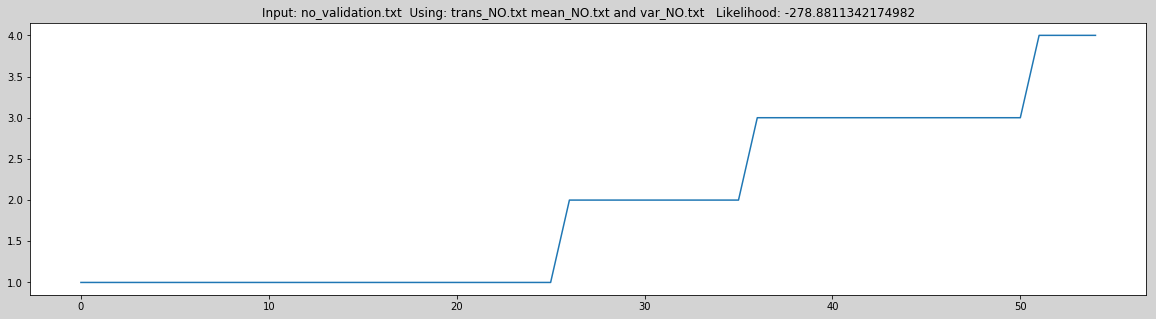

In [19]:
# validate no models
validate_no_yes = Viterbi("no_validation.txt","trans_YES.txt","mean_YES.txt","var_YES.txt")
validate_no_no = Viterbi("no_validation.txt","trans_NO.txt","mean_NO.txt","var_NO.txt")

# plot
validate_no_yes.plot_state()
validate_no_no.plot_state()

### Reordering of graphs

I noticed that figures are presented in a different order in the solution than in my initial submission. I am including this section, reproducing the same graphs that are in my initial solution, in an effort to make the grading easier for.

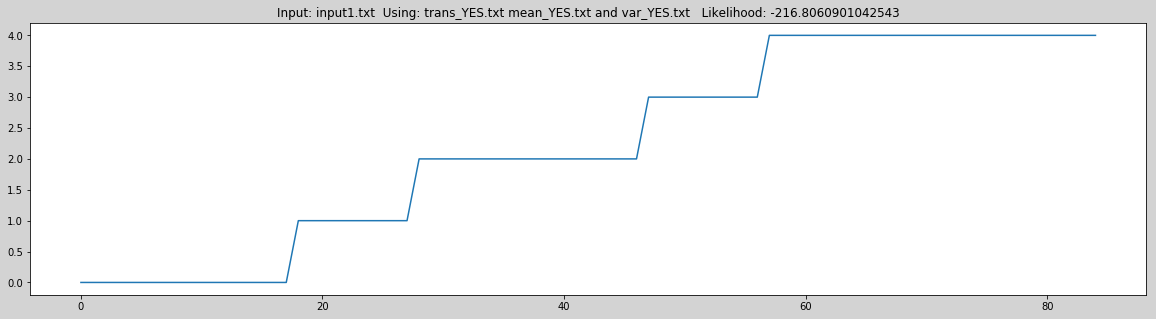

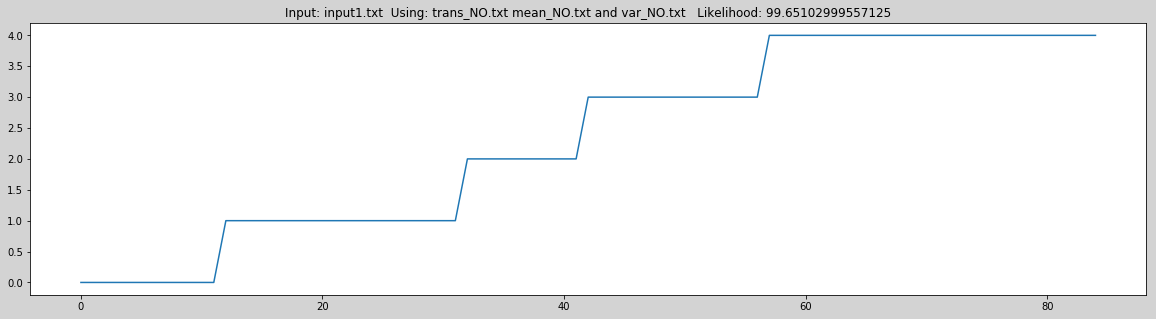

In [22]:
# input
input1_yes.plot_state()
input1_no.plot_state()

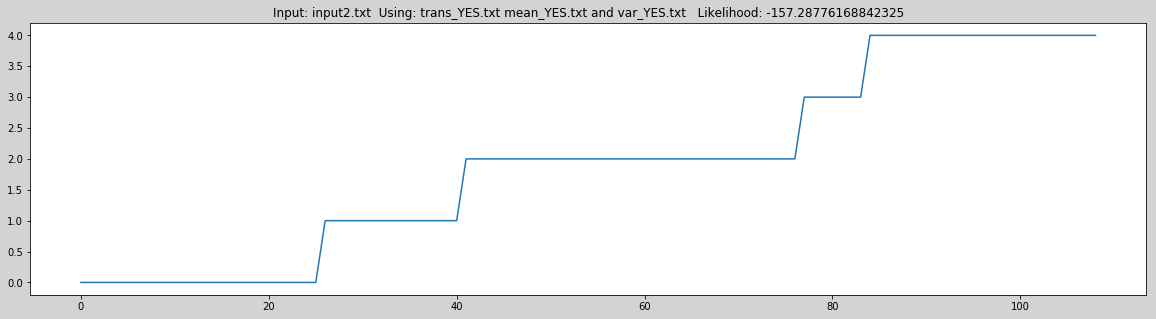

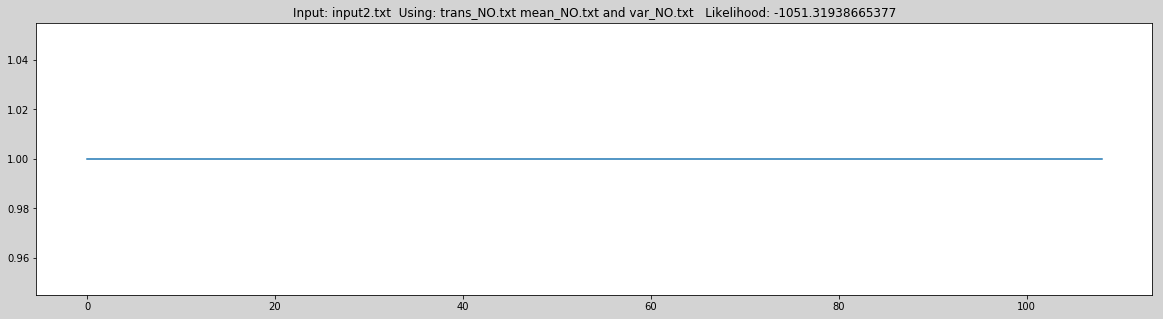

In [23]:
# input2.txt
input2_yes.plot_state()
input2_no.plot_state()


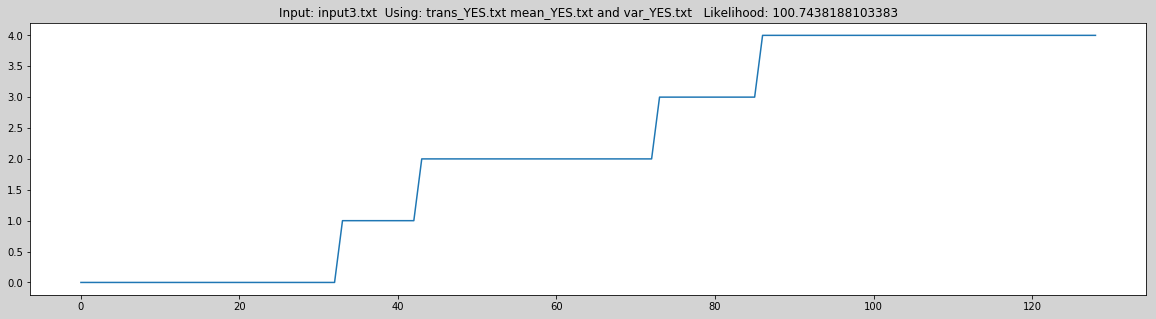

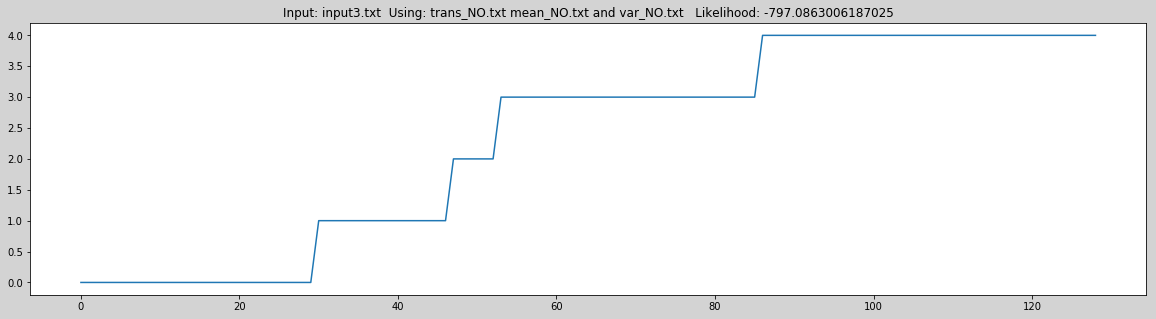

In [24]:
# input3.txt
input3_yes.plot_state()
input3_no.plot_state()